In [55]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import pandas as pd
import seaborn as sns


In [23]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'


In [24]:
# Function to extract features from a single audio file
def extract_features(audio_file, n_mfcc=13, n_fft=512):
    y, sr = librosa.load(audio_file, sr=None)
    if len(y) < n_fft:
        y = np.pad(y, (0, max(0, n_fft - len(y))), mode='constant')
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft)
    return np.mean(mfccs.T, axis=0)

# Directory containing audio files
audio_directory = r'C:\Users\alina\Desktop\ailabs\rainforest'
audio_files = [os.path.join(audio_directory, f) for f in os.listdir(audio_directory) if f.endswith('.wav')]

# Extract features for all files
features = np.array([extract_features(file) for file in audio_files])

# Normalize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

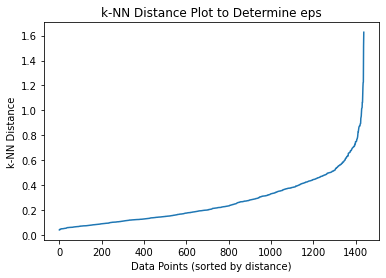

In [25]:
# Compute k-NN distances (k=2 corresponds to min_samples=2)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features_scaled)
distances, indices = nbrs.kneighbors(features_scaled)

# Sort distances in ascending order and plot
distances = np.sort(distances[:, 1], axis=0)
plt.plot(distances)
plt.ylabel('k-NN Distance')
plt.xlabel('Data Points (sorted by distance)')
plt.title('k-NN Distance Plot to Determine eps')
plt.show()

In [26]:
best_score = -1
best_params = {'eps': None, 'min_samples': None}

# Define a range for `eps` based on your k-NN plot
eps_range = np.linspace(0.2, 1.0, 10)

# Define a range for `min_samples`
min_samples_range = range(2, 10)

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(features_scaled)
        
        # Ignore cases where all points are labeled as noise
        if len(set(labels)) > 1:
            score = silhouette_score(features_scaled, labels)
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print(f"Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")

Best parameters: eps=1.0, min_samples=6


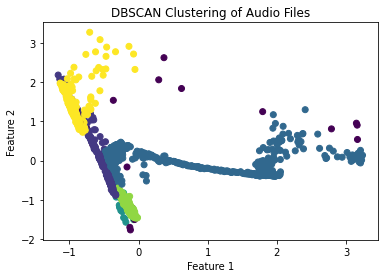

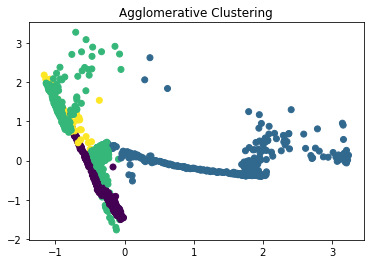

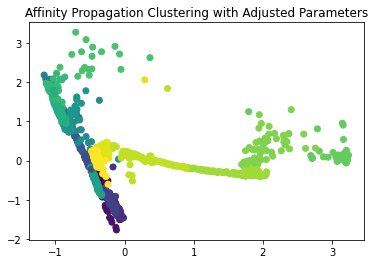

In [63]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.0, min_samples=6)  
dbscan.fit(features_scaled)

# Visualize the clusters
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=dbscan.labels_, cmap='viridis')
plt.title('DBSCAN Clustering of Audio Files')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

from sklearn.cluster import AgglomerativeClustering


# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4) 
agg_labels = agg_clustering.fit_predict(features_scaled)

# Plotting the clusters
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=agg_labels, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.show()

from sklearn.cluster import AffinityPropagation

# Affinity Propagation with adjusted parameters
affinity_propagation = AffinityPropagation(damping=0.9, max_iter=1000, preference=-50, random_state=42)
affinity_labels = affinity_propagation.fit_predict(features_scaled)

# Plotting the clusters
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=affinity_labels, cmap='viridis')
plt.title('Affinity Propagation Clustering with Adjusted Parameters')
plt.show()


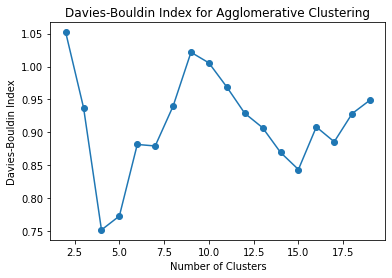

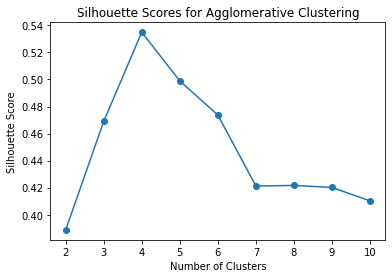

In [65]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

n_clusters_range = range(2, 20)
davies_bouldin_scores = []

# Compute Davies-Bouldin Index for each number of clusters
for n_clusters in n_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglo.fit_predict(features_scaled)
    davies_bouldin_scores.append(davies_bouldin_score(features_scaled, cluster_labels))

# Plot Davies-Bouldin Index scores
plt.plot(n_clusters_range, davies_bouldin_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Agglomerative Clustering')
plt.show()


n_clusters_range = range(2, 11)  # Start from 2 as silhouette score is undefined for 1 cluster
silhouette_avg = []

# Compute silhouette scores for each number of clusters
for n_clusters in n_clusters_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglo.fit_predict(features_scaled)
    silhouette_avg.append(silhouette_score(features_scaled, cluster_labels))

# Plot silhouette scores
plt.plot(n_clusters_range, silhouette_avg, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.show()

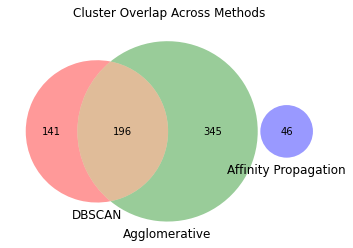

In [64]:
# Create sets for each cluster label from each algorithm
dbscan_clusters = [set(np.where(dbscan.labels_ == i)[0]) for i in np.unique(dbscan.labels_) if i != -1]
agg_clusters = [set(np.where(agg_labels == i)[0]) for i in np.unique(agg_labels)]
affinity_clusters = [set(np.where(affinity_labels == i)[0]) for i in np.unique(affinity_labels)]
from matplotlib_venn import venn3

# Consider creating sets for the first cluster from each method for simplicity
set1 = dbscan_clusters[0]
set2 = agg_clusters[0]
set3 = affinity_clusters[0]

# Venn diagram with the first cluster from each method
venn3([set1, set2, set3], ('DBSCAN', 'Agglomerative', 'Affinity Propagation'))
plt.title('Cluster Overlap Across Methods')
plt.show()


In [ ]:
# Assuming features_scaled is your scaled features array
# Create a DataFrame from your scaled features with automatically generated column names
df = pd.DataFrame(features_scaled, columns=[f'Feature{i+1}' for i in range(features_scaled.shape[1])])

# Add cluster labels to the DataFrame
df['DBSCAN_Cluster'] = dbscan.labels_
df['Agglomerative_Cluster'] = agg_labels
df['Affinity_Cluster'] = affinity_labels

# Group by cluster and calculate summary statistics
dbscan_summary = df.groupby('DBSCAN_Cluster').mean()
agg_summary = df.groupby('Agglomerative_Cluster').mean()
affinity_summary = df.groupby('Affinity_Cluster').mean()

"""
Display the summary statistics for each clustering method
print("DBSCAN Cluster Characteristics:\n", dbscan_summary)
print("Agglomerative Cluster Characteristics:\n", agg_summary)
print("Affinity Propagation Cluster Characteristics:\n", affinity_summary)
"""

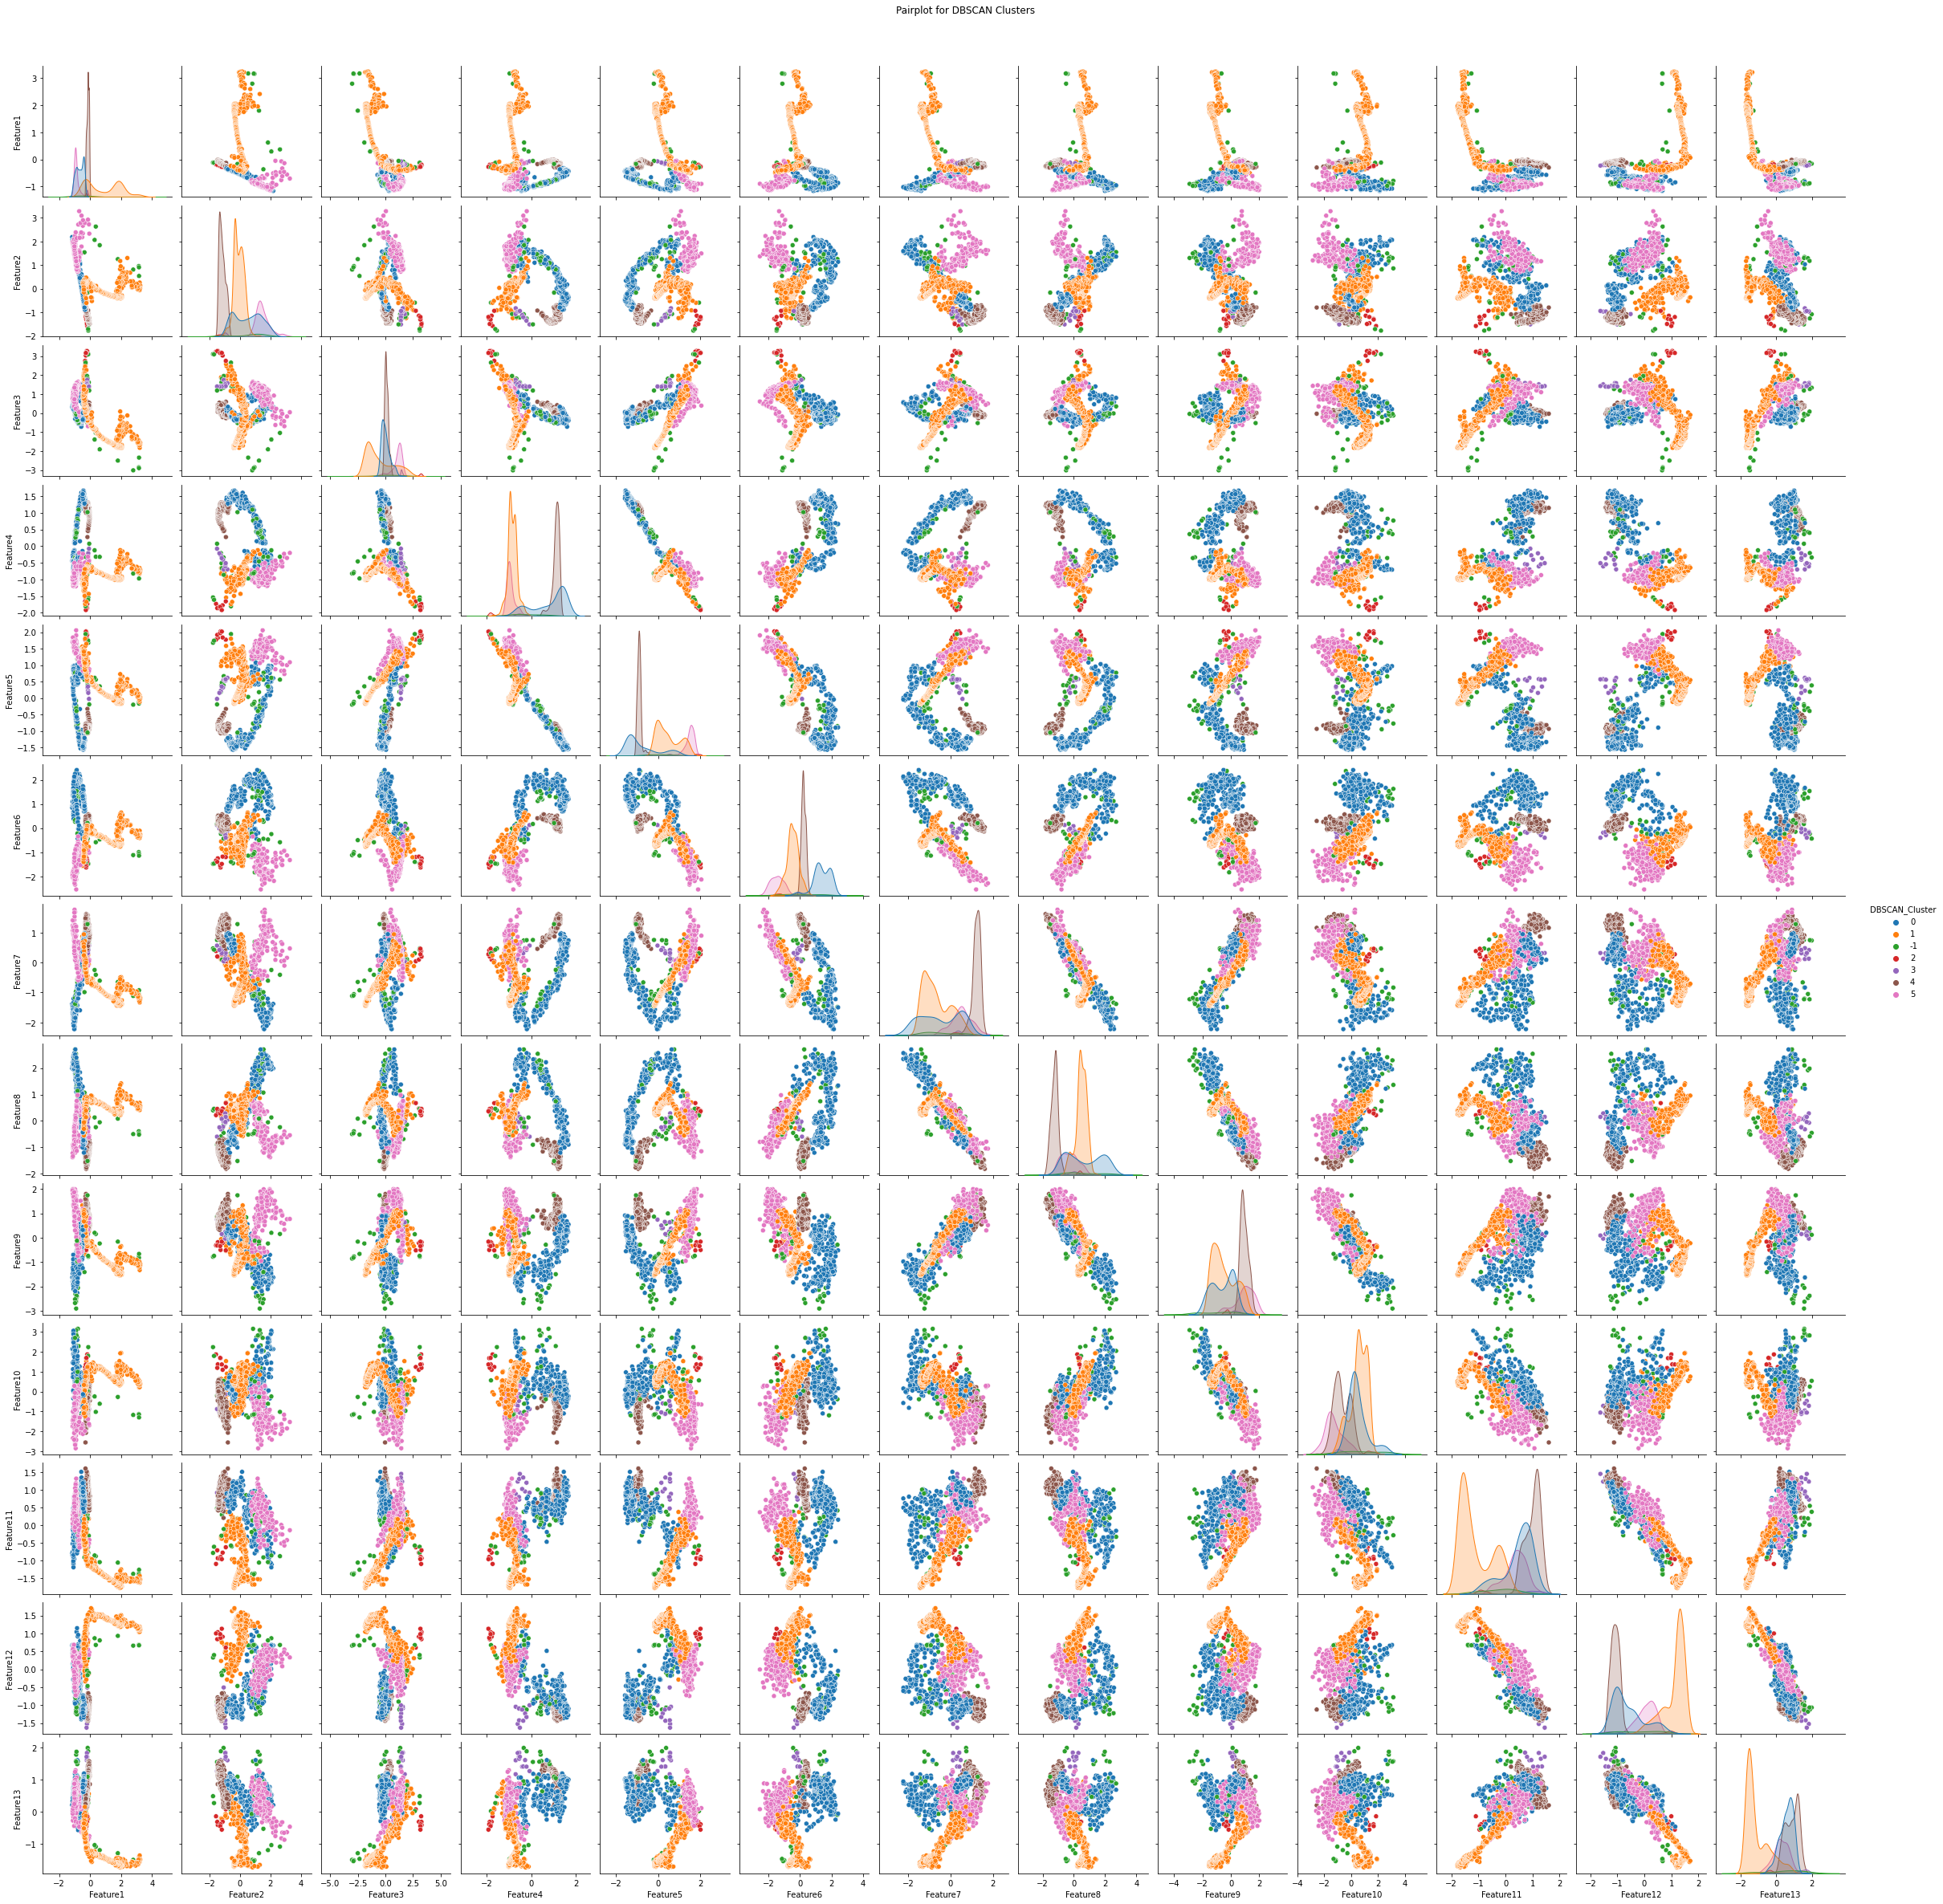

In [72]:
# Ensure clustering columns are treated as strings or categorical
df['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].astype(str)

# List of feature columns (excluding clustering columns)
feature_columns = df.columns[df.columns.str.contains('Feature')]

# Pair plot for DBSCAN clusters
sns.pairplot(df, hue='DBSCAN_Cluster', vars=feature_columns)
plt.suptitle('Pairplot for DBSCAN Clusters', y=1.02)
plt.show()


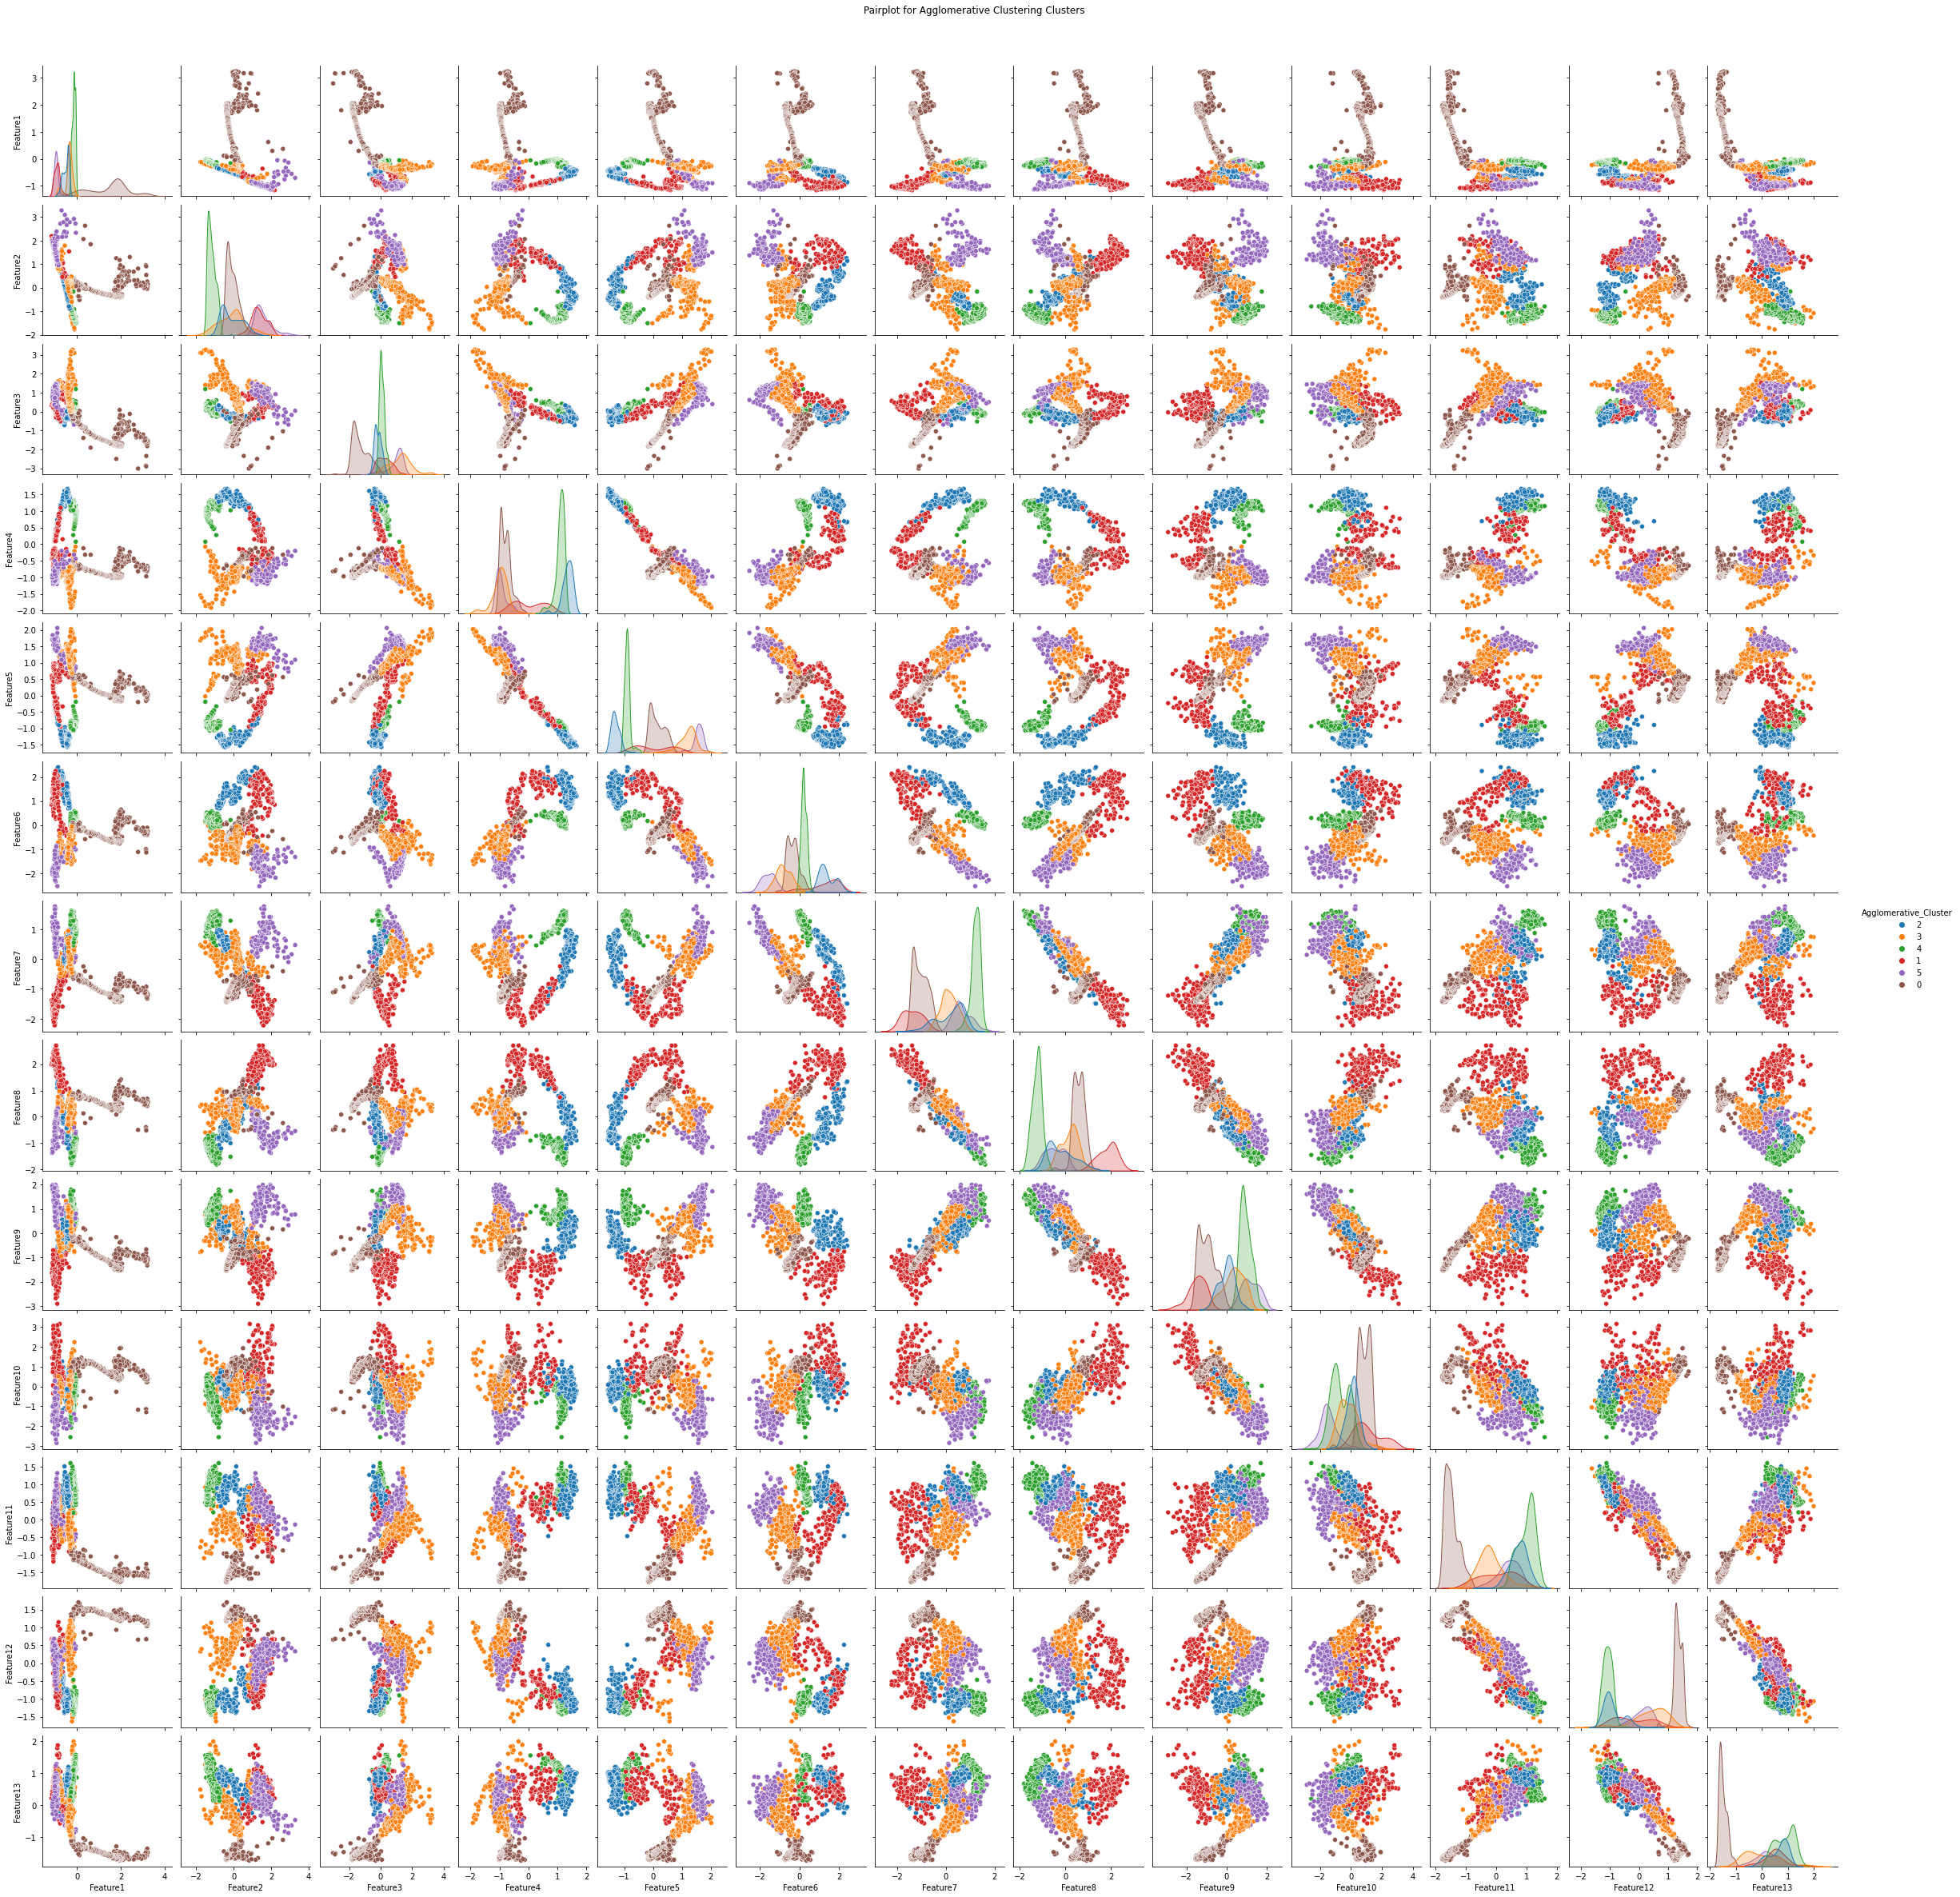

In [73]:
df['Agglomerative_Cluster'] = df['Agglomerative_Cluster'].astype(str)

# Pair plot for Agglomerative Clustering clusters
sns.pairplot(df, hue='Agglomerative_Cluster', vars=feature_columns)
plt.suptitle('Pairplot for Agglomerative Clustering Clusters', y=1.02)
plt.show()


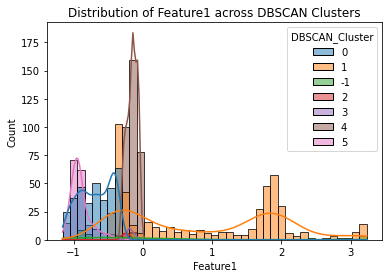

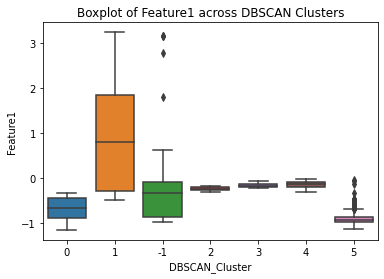

In [74]:
sns.histplot(df, x='Feature1', hue='DBSCAN_Cluster', kde=True)
plt.title('Distribution of Feature1 across DBSCAN Clusters')
plt.show()

sns.boxplot(x='DBSCAN_Cluster', y='Feature1', data=df)
plt.title('Boxplot of Feature1 across DBSCAN Clusters')
plt.show()

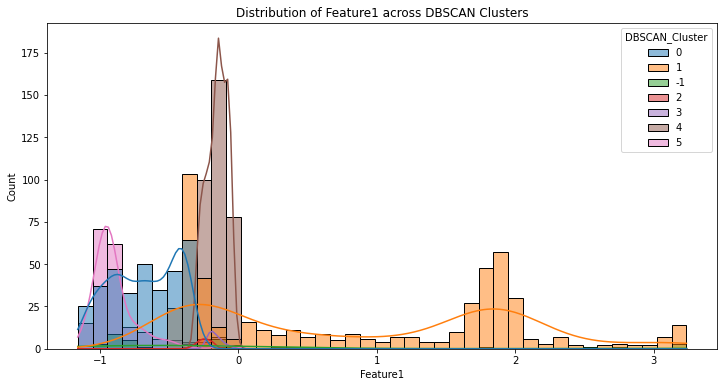

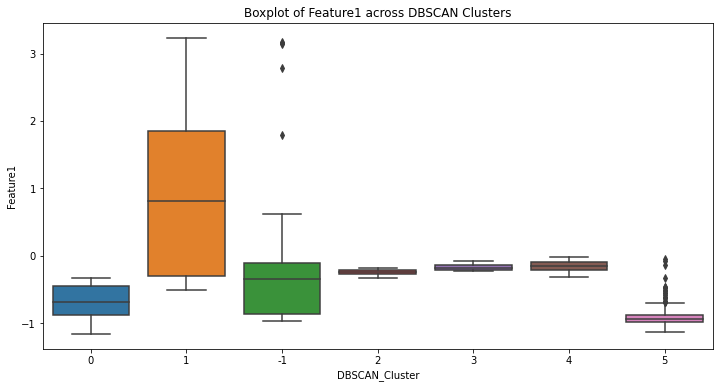

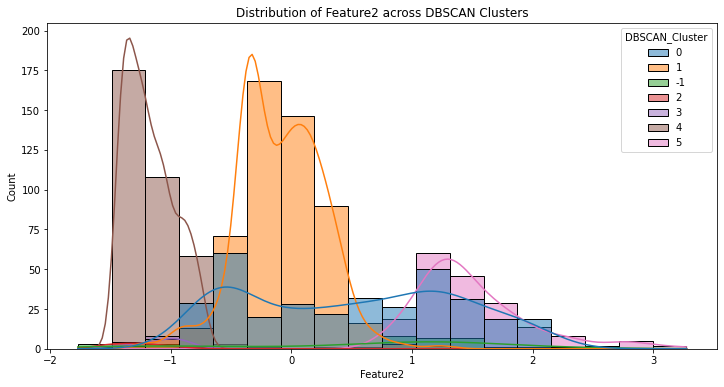

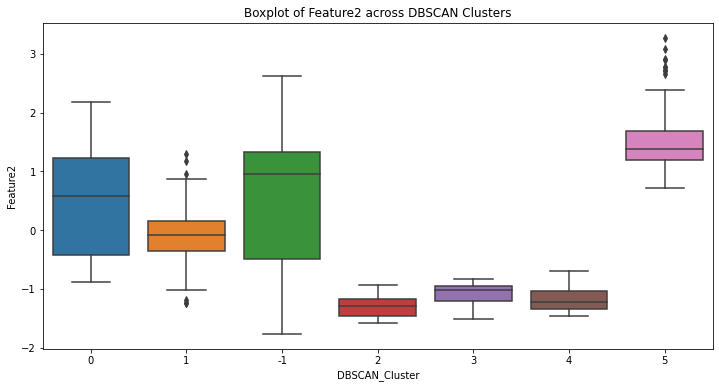

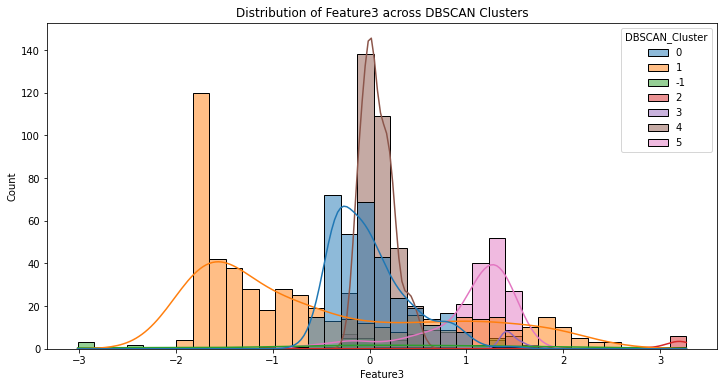

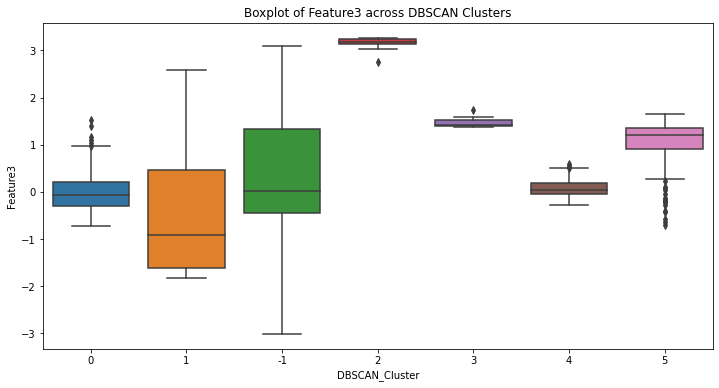

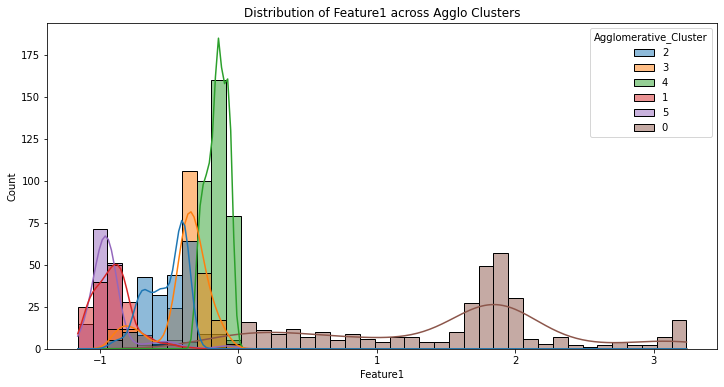

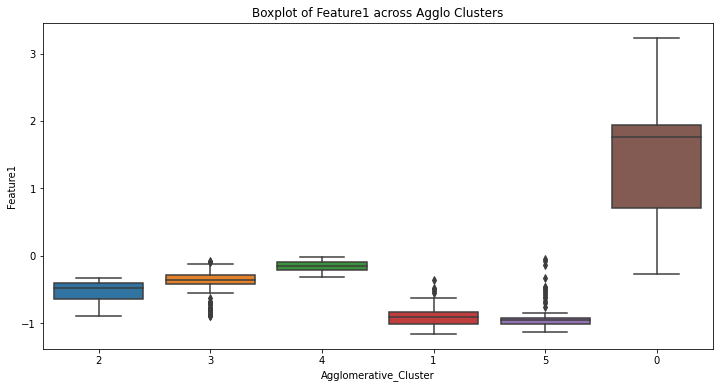

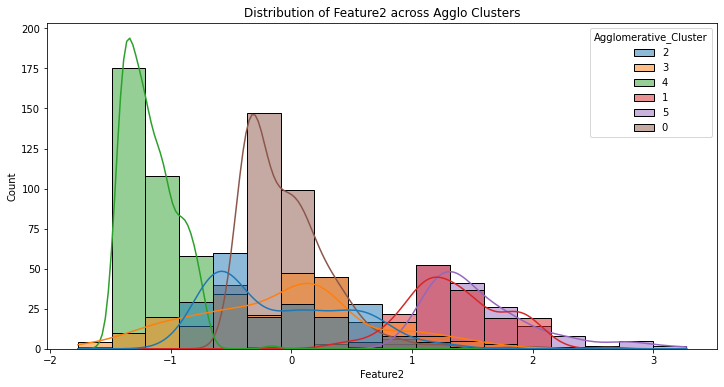

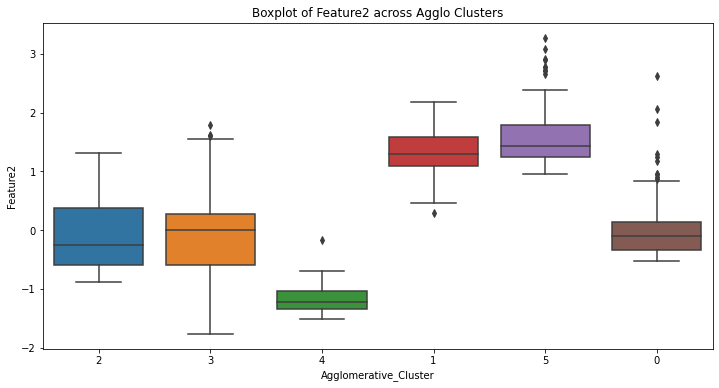

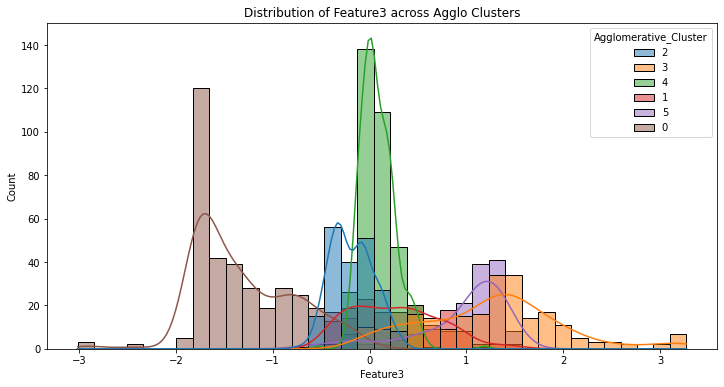

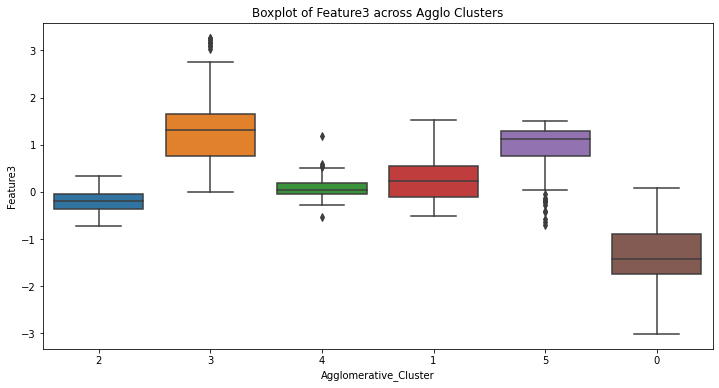

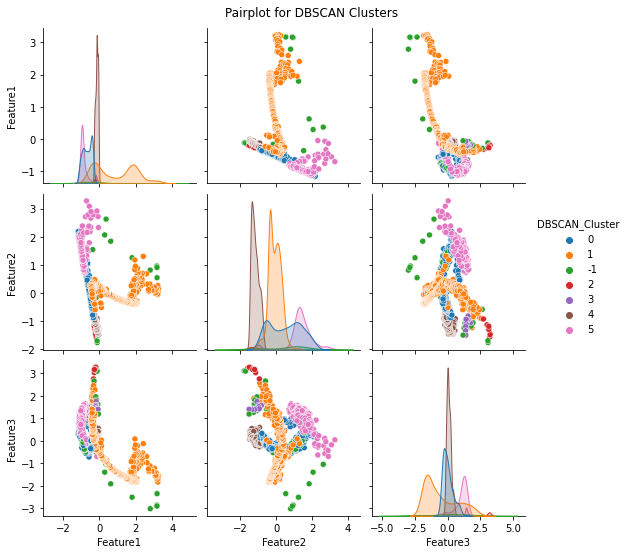

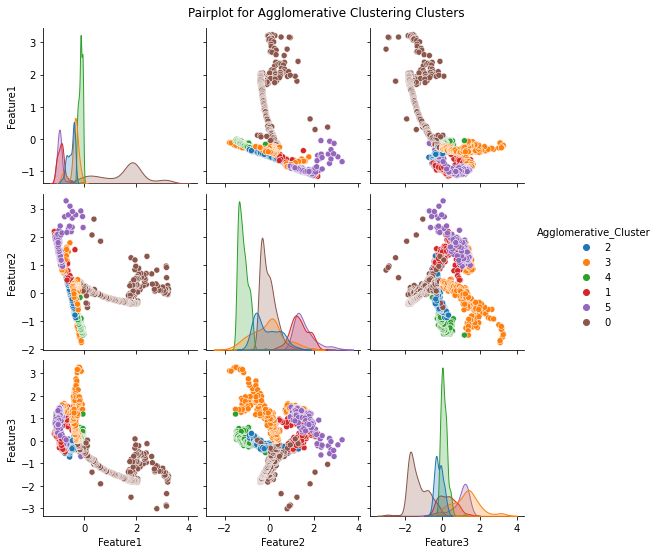

In [76]:

# Ensure clustering columns are treated as strings or categorical
df['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].astype(str)
df['Agglomerative_Cluster'] = df['Agglomerative_Cluster'].astype(str)

# List of feature columns (excluding clustering columns) and select the first three
feature_columns = df.columns[:-2]  # Exclude clustering columns
first_three_features = feature_columns[:3]  # Select the first three features

# Histogram and Boxplot for DBSCAN
for feature in first_three_features:
    # Histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(df, x=feature, hue='DBSCAN_Cluster', kde=True)
    plt.title(f'Distribution of {feature} across DBSCAN Clusters')
    plt.show()

    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='DBSCAN_Cluster', y=feature, data=df)
    plt.title(f'Boxplot of {feature} across DBSCAN Clusters')
    plt.show()

# Histogram and Boxplot for Agglomerative Clustering
for feature in first_three_features:
    # Histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(df, x=feature, hue='Agglomerative_Cluster', kde=True)
    plt.title(f'Distribution of {feature} across Agglo Clusters')
    plt.show()

    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Agglomerative_Cluster', y=feature, data=df)
    plt.title(f'Boxplot of {feature} across Agglo Clusters')
    plt.show()

# Pair plot to see relationships between the first three features for DBSCAN clusters
sns.pairplot(df, hue='DBSCAN_Cluster', vars=first_three_features)
plt.suptitle('Pairplot for DBSCAN Clusters', y=1.02)
plt.show()

# Pair plot to see relationships between the first three features for Agglomerative Clustering clusters
sns.pairplot(df, hue='Agglomerative_Cluster', vars=first_three_features)
plt.suptitle('Pairplot for Agglomerative Clustering Clusters', y=1.02)
plt.show()


In [58]:
df = pd.DataFrame(features_scaled, columns=[f'Feature{i+1}' for i in range(features_scaled.shape[1])])

# Add cluster labels to the DataFrame
df['DBSCAN_Cluster'] = dbscan.labels_
df['Agglomerative_Cluster'] = agg_labels
df['Affinity_Cluster'] = affinity_labels

# Function to create a profile for each cluster
def cluster_profiling(df, cluster_column):
    profile = df.groupby(cluster_column).agg(['mean', 'median', 'std']).reset_index()
    profile.columns = ['_'.join(col).strip() for col in profile.columns.values]
    return profile

# Profile DBSCAN Clusters
dbscan_profile = cluster_profiling(df, 'DBSCAN_Cluster')
print("DBSCAN Cluster Profile:\n", dbscan_profile)


DBSCAN Cluster Profile:
    DBSCAN_Cluster_  Feature1_mean  Feature1_median  Feature1_std  \
0               -1      -0.069813        -0.340833      1.208062   
1                0      -0.685186        -0.679976      0.237716   
2                1       0.884005         0.806797      1.111967   
3                2      -0.245176        -0.246343      0.046845   
4                3      -0.170701        -0.183831      0.046331   
5                4      -0.155869        -0.147488      0.073760   
6                5      -0.893757        -0.937030      0.172947   

   Feature2_mean  Feature2_median  Feature2_std  Feature3_mean  \
0       0.525359         0.951043      1.160342       0.152779   
1       0.506753         0.581222      0.876606       0.008880   
2      -0.087824        -0.089205      0.349183      -0.524679   
3      -1.294943        -1.287162      0.209842       3.130889   
4      -1.091008        -1.016759      0.201546       1.475530   
5      -1.172966        -1.217759 

In [49]:

# Profile Agglomerative Clusters
agg_profile = cluster_profiling(df, 'Agglomerative_Cluster')
print("\nAgglomerative Cluster Profile:\n", agg_profile)



Agglomerative Cluster Profile:
    Agglomerative_Cluster_  Feature1_mean  Feature1_median  Feature1_std  \
0                       0       0.748295         0.866990      1.324815   
1                       1      -0.290334        -0.224511      0.205314   
2                       2      -0.601565        -0.447727      0.316869   

   Feature2_mean  Feature2_median  Feature2_std  Feature3_mean  \
0       0.385687         0.095349      0.744592      -0.827009   
1      -0.778964        -0.992327      0.636227      -0.013551   
2       0.581204         0.399025      1.026066       1.138467   

   Feature3_median  Feature3_std  ...  Feature12_std  Feature13_mean  \
0        -0.973821      0.877569  ...       0.801043       -0.878709   
1        -0.003929      0.229395  ...       0.256975        0.786376   
2         1.208801      0.658853  ...       0.513111        0.075558   

   Feature13_median  Feature13_std  DBSCAN_Cluster_mean  \
0         -1.415292       0.973033             0.6344

In [50]:

# Profile Affinity Propagation Clusters
affinity_profile = cluster_profiling(df, 'Affinity_Cluster')
print("\nAffinity Propagation Cluster Profile:\n", affinity_profile)


Affinity Propagation Cluster Profile:
     Affinity_Cluster_  Feature1_mean  Feature1_median  Feature1_std  \
0                   0      -0.318864        -0.320966      0.067422   
1                   1      -0.226805        -0.237411      0.066799   
2                   2      -0.155033        -0.163544      0.051283   
3                   3      -0.082166        -0.079772      0.027749   
4                   4      -0.201113        -0.194769      0.053785   
5                   5      -0.541908        -0.554580      0.052493   
6                   6      -0.716268        -0.703167      0.068317   
7                   7      -0.957090        -0.955136      0.082916   
8                   8      -0.863053        -0.857806      0.047085   
9                   9      -1.047530        -1.056415      0.057670   
10                 10      -0.726128        -0.774629      0.136027   
11                 11      -0.764019        -0.786993      0.144241   
12                 12      -0.404118 